In [308]:
import os
import pandas as pd
from tqdm import tqdm
import vqa_logger 
import logging
from pathlib import Path
import datetime
from common import DAL
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
logger = logging.getLogger(__name__)

In [309]:
df_models = DAL.get_models_data_frame()
df_models = df_models[['class_strategy', 'parameter_count', 'loss_function', 'trainable_parameter_count','activation', 'notes',]]
# 'model_location',
df_scores = DAL.get_partial_scores_data_frame()
df_question_categories = DAL.get_question_categories_data_frame()
df_evaluation_types = DAL.get_evaluation_types_data_frame()

In [310]:
# df_models.tail()

In [311]:
df_scores.tail()
df_scores.loc[120]

,evaluation_type,score,question_category_id
model_id,,,
120,2,0.000000,2
120,1,0.018950,2
120,2,0.000000,3
120,1,0.036392,3
120,2,0.272000,1
120,1,0.308453,1
120,3,0.000000,2
120,3,0.000000,3
120,3,0.272000,1


In [312]:
# df_question_categories

In [313]:
# df_evaluation_types

In [314]:
df = df_models.join(df_scores, how='inner')\
    .join(df_question_categories, on='question_category_id')\
    .join(df_evaluation_types, on='evaluation_type')\
    .sort_index(ascending=False)


df=df[['Category', 'name', 'score','class_strategy',  'loss_function','activation', 'parameter_count','trainable_parameter_count', 'notes']]
df= df[df.score >=0]
df.loc[[120,202],:]
# df.head()


,Category,name,score,class_strategy,loss_function,activation,parameter_count,trainable_parameter_count,notes
120,Organ,strict_accuracy,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Plane,bleu,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Plane,wbss,0.018950,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Organ,bleu,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Organ,wbss,0.036392,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,bleu,0.272000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,wbss,0.308453,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Plane,strict_accuracy,0.000000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Abnormality,strict_accuracy,0.018868,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."
120,Modality,strict_accuracy,0.272000,answers,cosine_proximity,sigmoid,20095104,61492,"post_concat_dense_units: (8, 6);\nOptimizer: R..."


### Get data from notes:

In [315]:
new_columns_data = \
{'post_concat_dense_units': None,
'Optimizer': None,
# 'loss': None,
'activation': None,
'prediction ': None,
'lstm_units': None,
'batch_size': None,
'epochs': None,
'class weights': False,
'Inputs Attention': False}

In [316]:
def note_to_lines(raw):
    n = raw
    for c in [';']:
        n = n.replace(c, '')
    lines = (l.strip() for l in n.split('\n'))
    lines = [l for l in lines if ': ' in l]
    return lines


raw = df.notes.values[0]
lines = note_to_lines(raw)
# print('\n'.join(lines))

def get_data_from_lines(lines, col_name):
    default_val = new_columns_data[col_name]
    relevant_lines = [l for l in lines if col_name in l]
    assert len(relevant_lines) <=1
    if len(relevant_lines) == 0:
        data = default_val
    else:
        line = relevant_lines[0]
        data_str = line.split(': ')[-1]
        try:
            data = eval(data_str)            
        except:
            data = data_str
        
    return data
print('-'*10)        
for col in new_columns_data:  
    data = get_data_from_lines(lines, col)
    print(f'{col}: {data}')


----------
post_concat_dense_units: (8,)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 128
batch_size: 32
epochs: 8
class weights: False
Inputs Attention: False


In [317]:
def notes_to_data(notes, col_name):
    lines =note_to_lines(notes)
    data = get_data_from_lines(lines, col_name)
    return data

for col in new_columns_data:  
    data = notes_to_data(raw, col)
    print(f'{col}: {data}')

post_concat_dense_units: (8,)
Optimizer: RMSprop
activation: softmax
prediction : answers
lstm_units: 128
batch_size: 32
epochs: 8
class weights: False
Inputs Attention: False


In [318]:
for col in new_columns_data:  
    df[col.replace(' ', '_')] = df.notes.apply(lambda notes: notes_to_data(notes, col))    


In [319]:
print(df.Category.drop_duplicates().values)
print(df.name.drop_duplicates().values)
print(df.post_concat_dense_units.values)

['Abnormality' 'Organ' 'Plane' 'Abnormality_yes_no' 'Modality']
['wbss' 'bleu' 'strict_accuracy']
[(8,) (8,) (8,) ... None None None]


In [320]:
def dense_layers_to_total(dense_str):
    if dense_str is None:
        return 8
    
    try:
        data = eval(str(dense_str))
    except:
        data = 8
    
    if not isinstance(data, int):
        data = sum(data)
    
    return data
        
    

In [321]:
df['total_dens_units'] = df.post_concat_dense_units.apply(dense_layers_to_total).astype(int)

## Plot results

In [322]:
cmaps = [c for c in dir(plt.cm) if not c.startswith('_')] 
try:
    i += 1
except:
    i = 0

cmap = cmaps[i]
# cmap = "Blues"
# cmap = plt.cm.jet
# cmap ='Accent'
cmap = 'Paired'

In [323]:
df.columns

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention',
       'total_dens_units'],
      dtype='object')

____

In [324]:
category =None#'Abnormality'#
evaluation = 'strict_accuracy'# 'bleu'#
evaluation_idxs = (df.name==evaluation) | (evaluation is None)
category_idx = ((df.Category==category) | (category is None))
cdf = df[evaluation_idxs & category_idx]

print(cdf.columns)
cdf.sort_values(by='score', ascending=False)[['name','Category']].drop_duplicates()

Index(['Category', 'name', 'score', 'class_strategy', 'loss_function',
       'activation', 'parameter_count', 'trainable_parameter_count', 'notes',
       'post_concat_dense_units', 'Optimizer', 'prediction_', 'lstm_units',
       'batch_size', 'epochs', 'class_weights', 'Inputs_Attention',
       'total_dens_units'],
      dtype='object')


,name,Category
120,strict_accuracy,Abnormality_yes_no
188,strict_accuracy,Plane
220,strict_accuracy,Modality
70,strict_accuracy,Organ
224,strict_accuracy,Abnormality


In [325]:
label = 'prediction_'

# x_name = 'trainable_parameter_count'
# y_name = 'score'
# sizes_name = 'parameter_count'


# x_name = 'prediction_'
# y_name = 'score'

x_name = 'Category'
y_name = 'score'


# x_name = 'epochs'
# y_name = 'score'

# x_name = 'loss_function'
# y_name = 'score'



# sizes_name = 'trainable_parameter_count'
# sizes_name ='total_dens_units'
# # sizes_name ='epochs'
# sizes_name = 'batch_size'



columns = list({x_name, y_name, 'notes',sizes_name, label})
df_plot = cdf[columns]

# df_plot = df_plot.sort_values(by=sizes_name)
df_plot.loc[:,sizes_name] = (1+cdf[sizes_name])/2

# df_plot.loc[: , 'batch_size'] = df_plot.batch_size.fillna(32)
# df_plot.loc[: , 'epochs'] =df_plot.epochs.fillna(10)

print(cmap)
print(len(cdf))
df_plot.sample(5)

Paired
609


,parameter_count,notes,prediction_,score,Category
17,10034580.0,post_concat_dense_units: 32;\nOptimizer: Adam\...,words,0.000,Organ
128,10047552.5,"post_concat_dense_units: (8, 6);\nOptimizer: R...",answers,0.000,Organ
102,10048472.0,"post_concat_dense_units: (7, 6, 8);\nOptimizer...",words,0.000,Plane
108,10050022.0,"post_concat_dense_units: (8, 6, 7);\nOptimizer...",words,0.000,Plane
133,10051736.0,"post_concat_dense_units: (9, 8);\nOptimizer: R...",answers,0.296,Modality


In [326]:
is_categorial = df_plot.dtypes[x_name] in (object, bool)
is_categorial
# df_plot.dtypes

True

In [327]:
hash('sdsd')

8972030102234759321

In [328]:
%matplotlib qt  
# wx, gtk, osx, tk #inline
sns.set(style="white", color_codes=True)

size = cdf[sizes_name].values
sizes=(75, 500) #(min(size), max(size)
if is_categorial:
    jitter=0.02
    ax = sns.stripplot(x=x_name, y=y_name, data=cdf, alpha=.2, jitter=jitter,size=25, edgecolor='gray')#size=size, size=z,sizes=sizes, 
elif True:
#     s_p2 = size **2
    for curr_label, curr_df in cdf.groupby(label):
        plt.scatter(curr_df[x_name], curr_df[y_name], s=s_p2, sizes=sizes,  label=curr_label, cmap=cmap, alpha=.3, edgecolors="grey", linewidth=2)
    plt.legend()
else:    
    ax = sns.scatterplot(x=x_name, y=y_name, data=cdf, hue=y_name,  palette=cmap, alpha=.3, edgecolor='gray')#, size=sizes_name, sizes=sizes)
    
sns.despine()
 
# Add titles (main and on axis)
plt.xlabel(x_name.replace('_', ' '))
plt.ylabel(y_name.replace('_', ' '))
category_str = category if category else 'All Categories'
plt.title(f"'{evaluation}' for '{category_str}' (size={sizes_name})", {'fontsize': 18})
 
# plt.show()


Text(0.5, 1.0, "'strict_accuracy' for 'All Categories' (size=parameter_count)")

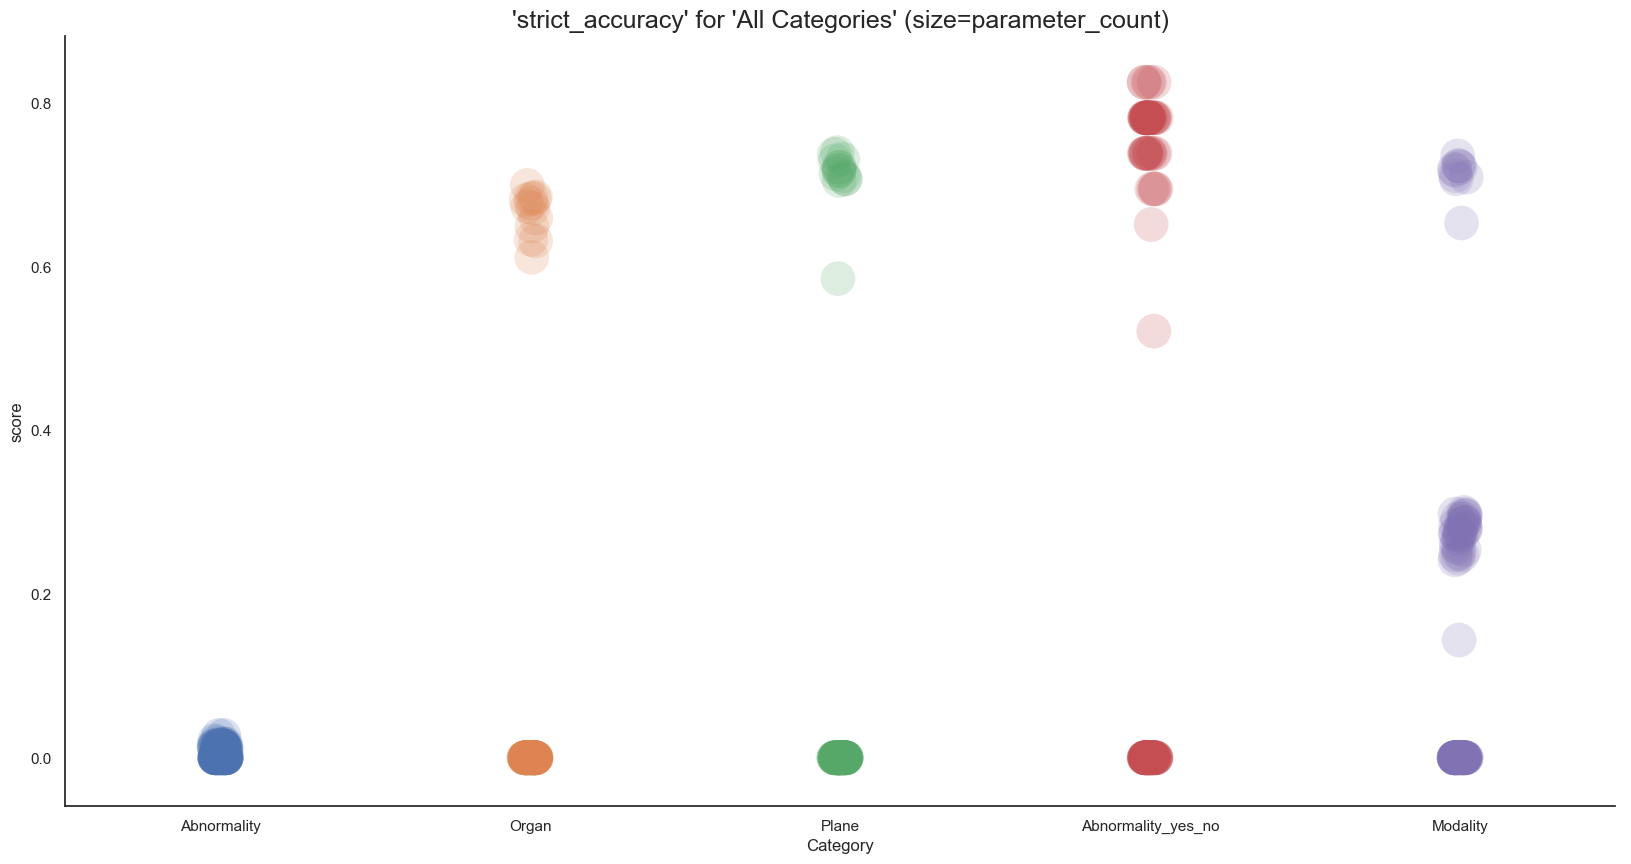

In [329]:
fig = plt.gcf()
plt.rcParams['figure.figsize'] = [20, 10]
fig